In [1]:
import importlib
import sys
import h5py
import scipy.io
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.linalg import logm,expm, sqrtm
from scipy.stats import zscore
from scipy.stats import mode
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import pairwise_distances
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.optim as optim


sys.path.insert(0, "D:/PhD/tangent_space_analysis/")
                
import TSAfuncs as tsa
importlib.reload(tsa)

c:\Users\davcu\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\davcu\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\davcu\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\davcu\AppData\Local\Temp\ipykernel_14204\1022575765.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arro

<module 'TSAfuncs' from 'D:\\PhD/tangent_space_analysis\\TSAfuncs.py'>

In [2]:
ROI = scipy.io.loadmat('filteredROI.mat')
ROI = ROI['ROItokeep']
nparcels = [100, 400, 1000]
ROI_to_keep = dict()
for i,n in enumerate(nparcels):
    ROI_to_keep[n] = ROI[0][i][0]


In [3]:


parent_dir = os.getcwd()

#parent_dir = 'parent dir here'
dfOG = pd.read_csv(parent_dir + "\\" + 'allRecordings_dataframe.csv')

dfOG = dfOG[dfOG['numparcels'] == 100]
# dfOG = dfOG[(dfOG['Num Subnets'] == 17) & (dfOG['Num Parcels'] == 300)]
# tasklist = ['Rest', 'Motor']#, 'Memory']
FCs = list()

# rest_df = pd.DataFrame()
# dfOG.head(10)

for index,row in dfOG.iterrows():
    filename = row['filepath'] +'/' + 'FCs/' +'FC_' + row['subject'] + '_recid=' + str(row['recid']) + '.mat' #+ row['filename']
    filename = filename.replace( '/scratch2/DavorCuric/CANBIND/' ,"D:/PhD/CANBIND/")
    
    try:
        f = scipy.io.loadmat(filename)
        subject_id = str(row['subject'])
        state = int(row['controls'])*'controls' + int(row['nonresponders'])*'nonresponders' + int(row['responders'])*'responders'
        
        session = row['session']

        if state == 'controls':
            continue
        if state == '':
            continue

        FCs.append(tsa.FC(np.array(f['FC']), subject = subject_id, state = state, session = session))
    except:
        print('file not found: ' + filename)
    

file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01CAM0005_recid=710.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01MCU0011_recid=729.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01MCU0055_recid=757.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01TGH0002_recid=794.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01TGH0077_recid=825.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01TGH0078_recid=826.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01TGH0080_recid=828.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01UBC0049_recid=859.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01UBC0067_recid=876.mat
file not found: D:/PhD/CANBIND/CANBIND_WK2_100_PARCELS/FCs/FC_CBN01UCA0024_recid=893.mat
file not found: D:/PhD/CANBIND/CANBIND_WK8_100_PARCELS/FCs/FC_CBN01CAM0005_recid=1244.mat
file not found: D:/P

In [5]:
trt = tsa.test_retest(FCs)
regvals = np.linspace(4,4,1)
score = trt.ts_test_retest(regvals)#, refinv = 'logm')
score_classic = trt.classic_test_retest()
print('tangent space score = ' + str(score) + ', non-tangent space score = ' + str(score_classic))


tangent space score = 0.8495934959349576, non-tangent space score = 0.8495934959349576


In [256]:
#generate tangent space projection
regvals = np.linspace(4,4,1)
for reg in regvals:
    [x.tangent_space_projection(reg = 10**reg) for x in FCs];

In [189]:
regflow, df = tsa.get_regularization_flow(FCs, 10**regvals)

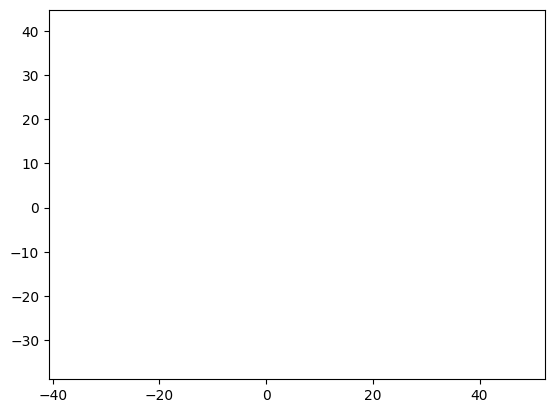

In [190]:

# #Perform PCA
pca = PCA(n_components=20)  # Reduce to 2 dimensions
score = pca.fit_transform(regflow)  # Transformed data
 
#Step 2: Extract the First Two Principal Components
Y = score[:, :20]
tsa.plot_regflow_pca(Y, 18, df, labels = df['state'].values)


In [257]:
regflow, df = tsa.get_regularization_flow(FCs, [10**4])
df['index'] = df.index
# Filter subjects that have all three sessions ('BASELINE', 'WK2', 'WK8')
valid_subjects = df.groupby('subject').filter(
    lambda group: set(group['session']) == {'BASELINE', 'WK2', 'WK8'}
)['subject'].unique()

# Keep only rows corresponding to valid subjects
df = df[df['subject'].isin(valid_subjects)]
#df.sort_values(by = ['index'], inplace = True)

regflow = regflow[df['index'].values]
df = df.reset_index(drop = True)


In [208]:
# Define the neural network
class StatePredictor(nn.Module):
    def __init__(self, input_size):
        super(StatePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Filter data for BASELINE and WK2 sessions
baseline_wk2 = df[df['session'].isin(['BASELINE', 'WK2'])]

# Extract the indices of the filtered rows
baseline_wk2_indices = baseline_wk2.index

# Use the indices to select the corresponding rows from regflow
baseline_wk2_regflow = regflow[baseline_wk2_indices]

# Aggregate features for each subject by concatenating regflow rows for BASELINE and WK2
X = baseline_wk2.groupby('subject').apply(
    lambda group: np.concatenate(baseline_wk2_regflow[group.index], axis=0)
).values

Y = np.zeros((len(X), np.shape(regflow)[1]*2))
for i,val in enumerate(X):
    Y[i][:] = val

# Extract target labels for WK8
wk8 = df[df['session'] == 'WK8']
wk8_indices = wk8.index
y = wk8.set_index('subject')['state'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Y, y, test_size=0.2)

C:\Users\davcu\AppData\Local\Temp\ipykernel_18588\1462709792.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X = baseline_wk2.groupby('subject').apply(


In [209]:
# Initialize the model
input_size = X_train.shape[1]
model = StatePredictor(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 0.5899
Epoch [20/200], Loss: 0.5112
Epoch [30/200], Loss: 0.4382
Epoch [40/200], Loss: 0.3693
Epoch [50/200], Loss: 0.3059
Epoch [60/200], Loss: 0.2499
Epoch [70/200], Loss: 0.2014
Epoch [80/200], Loss: 0.1604
Epoch [90/200], Loss: 0.1268
Epoch [100/200], Loss: 0.1002
Epoch [110/200], Loss: 0.0796
Epoch [120/200], Loss: 0.0639
Epoch [130/200], Loss: 0.0519
Epoch [140/200], Loss: 0.0427
Epoch [150/200], Loss: 0.0355
Epoch [160/200], Loss: 0.0299
Epoch [170/200], Loss: 0.0255
Epoch [180/200], Loss: 0.0219
Epoch [190/200], Loss: 0.0190
Epoch [200/200], Loss: 0.0167


In [210]:
# Evaluate the model
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()
    predictions = (predictions > 0.5).numpy()
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.3333


In [260]:
baseline_idx = df['session'] == 'BASELINE'
wk2_idx = df['session'] == 'WK2'
wk8_idx = df['session'] == 'WK8'

df_baseline = df[baseline_idx].copy()
df_wk2 = df[wk2_idx].copy()
df_wk8 = df[wk8_idx].copy()

# Assuming the regflow rows correspond in order to df rows
# Get regflow for each session (you may need to adjust indexing if order differs)


# Optionally reduce dimensionality with PCA
pca = PCA(n_components=50)  # Adjust n_components as needed
regflow_reduced = pca.fit_transform(regflow)
# Remove the first 3 principal components (columns)
regflow_reduced = regflow_reduced[:, 11:]

regflow_baseline = regflow_reduced[baseline_idx, :]
regflow_wk2 = regflow_reduced[wk2_idx, :]

# Merge baseline and wk2 data by subject
merged = pd.merge(df_baseline[['subject']], df_wk2[['subject']], on='subject', suffixes=('_baseline', '_wk2'))

# Create feature matrix by combining regflow data from baseline and wk2 for each subject
# (This assumes subjects are in the same order; if not, you need to align based on subject IDs)
features_baseline = regflow_baseline
features_wk2 = regflow_wk2
X = np.hstack([features_baseline, features_wk2])  # shape: (num_subjects, 2*M)

# Create target vector from wk8 state; encode responder (1) and nonresponder (0)
target = df_wk8['state'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2)

# Train a logistic regression model (with regularization)
model = LogisticRegression(penalty='l2', solver='liblinear')
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)

Accuracy: 0.4166666666666667
ROC AUC: 0.37857142857142856


In [41]:
def get_closest_subjects(df,regflow, regvals, method = 'correlation'):
    #get the closest non-self tsfc to each tsfc in regflow and store it in the dataframe
    df['closest'] = np.nan
    for r in regvals:
        idx = np.where(df['reg'].values == 10**r)[0]
        
        sub_regflow = regflow[idx][:]

        D = pairwise_distances(sub_regflow, metric = method)
        
        for m in range(np.shape(sub_regflow)[0]):
            D[m,m]=np.inf
            df.loc[idx[m], 'closest'] = df['subject'].values[idx][np.argmin(D[m,:])]

    return df

df = get_closest_subjects(df, regflow, regvals)
#    score = np.array([1 if x['closest'] == x['subject'] else 0 for i,x in df.iterrows()] )
#score = np.mean(score)
#print(score)

In [42]:
joint_labels, unique_joint_labels = tsa.get_join_labels(df)

score = 0
for label in unique_joint_labels:
    idx = [i for i,x in enumerate(joint_labels) if x == label]
    guess = mode(df.loc[idx, 'closest'].values)[0]
    if guess == label[0]:
        score = score + 1/len(unique_joint_labels)

print(score)


0.9080459770114934


In [2429]:
#subnetwork analysis
subnets = pd.read_csv('/home/dcuric/Documents/tangentSpace/MNSC/subnetworks.csv')
subnetid = subnets['subnet'].unique()

refidx = 1
accuracy_task = np.zeros(len(subnetid))
accuracy_subj = np.zeros(len(subnetid))
for s in subnetid:
  
    idx = list(subnets[subnets['subnet'] == s]['ROI'].values - 1)
    if len(idx) < 10:
        print(len(idx))
        print('here')
        continue
    print(idx)
    subFC = [f[idx,:][:,idx] for f in FCs]

    ref_FC, ref_df, test_FC, test_df = get_ref_and_test_FC(subFC, rest_df, refidx)#, subject)    
    print(np.shape(test_FC))
    print(np.shape(ref_FC))
    
    [regflow, subjects, sessions, tasks] = get_regularization_flow(test_FC, test_df, ref_FC = ref_FC, start = -2, stop = 4, step = 10)#, start = -2, stop = 4, steps = 5, num_components = 3)
    print(np.shape(regflow))
    categories = {'Rest':0, 'Motor':1, 'Memory':2}
    tasklabels = [categories[x] for x in tasks]
    
    # # #Perform PCA
    # pca = PCA(n_components=20)  # Reduce to 2 dimensions
    # score = pca.fit_transform(regflow)  # Transformed data
      
    # #Step 2: Extract the First Two Principal Components
    # Y = score[:, :20]
    #classifiy using SVM on PCA according to regularization trajectories
    labels_task = np.array(tasklabels)
    labels_subject = np.array(tasklabels)
    
    
    # 1. Create a DataFrame to organize the information
    df = pd.DataFrame({
        'subject': subjects,
        'task': tasklabels,
        'session': sessions,
        'index': np.arange(np.shape(regflow)[0])
    })
    
    # Create a composite key: for example, "subject_task_session"
    df['group'] = df.apply(lambda row: f"{row['subject']}_{row['task']}_{row['session']}", axis=1)
    
    #Sort the DataFrame so that rows from the same group are together
    df_sorted = df.sort_values(by=['group'])
    sorted_idx = df_sorted['index'].values
    
    # Reorder regflow and labels accordingly
    regflow_sorted = regflow[sorted_idx]
    labels_task_sorted = labels_task[sorted_idx]
    labels_subj_sorted = labels_subject[sorted_idx]
    
    
    # Also extract the group labels in the sorted order
    groups_sorted = df_sorted['group'].values
    
    # 3. Use GroupShuffleSplit to split the data by session (group)
    gss = GroupShuffleSplit(n_splits=2, test_size=0.2)#, random_state=39)
    train_idx, val_idx = next(gss.split(regflow_sorted, groups=groups_sorted))
    
    X_train = regflow_sorted[train_idx]
    X_val = regflow_sorted[val_idx]
    y_task_train = labels_task_sorted[train_idx]
    y_task_val = labels_task_sorted[val_idx]
    y_subj_train = labels_subj_sorted[train_idx]
    y_subj_val = labels_subj_sorted[val_idx]
    
     
    #apply pca
    pca = PCA(n_components=min(X_train.shape[1], X_train.shape[0]))  # Keep all PCs
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    #######classify the task
    pc_x = 7
    pc_y = pc_x + 1
    X_train_selected = X_train_pca[:, [pc_x, pc_y]]
    X_val_selected = X_val_pca[:, [pc_x, pc_y]]
    
    svm = SVC(kernel='linear', C=1, gamma='scale')
    svm.fit(X_train_selected, y_task_train)
    
    #predict the lbaels
    y_pred = svm.predict(X_val_selected)
    
    #Compute classification accuracy
    accuracy_task[s-1] = accuracy_score(y_task_val, y_pred)

    #######classify the subject
    pc_x = 0
    pc_y = pc_x + 1
    X_train_selected = X_train_pca[:, [pc_x, pc_y]]
    X_val_selected = X_val_pca[:, [pc_x, pc_y]]
    
    svm = SVC(kernel='linear', C=1, gamma='scale')
    svm.fit(X_train_selected, y_subj_train)
    
    #predict the lbaels
    y_pred = svm.predict(X_val_selected)
    
    #Compute classification accuracy
    accuracy_subj[s-1] = accuracy_score(y_subj_val, y_pred)
    
    
    

[10, 17, 18, 72, 114, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 132, 133, 134, 141, 143, 158, 171, 177, 178, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 290, 291, 295, 296, 299, 300, 301, 302, 303, 304, 305, 311, 313]
(85, 47, 47)
(8, 47, 47)
(850, 1081)
[0, 3, 5, 24, 25, 43, 93, 113, 115, 116, 125, 126, 144, 145, 149, 150, 151, 153, 155, 156, 161, 164, 183, 185, 199, 219, 224, 256, 258, 277, 278, 289, 314, 315, 320, 321, 322, 323, 324, 325, 330]
(85, 41, 41)
(8, 41, 41)
(850, 820)
[4, 7, 14, 15, 16, 19, 89, 96, 97, 98, 130, 131, 135, 136, 137, 138, 139, 140, 165, 168, 174, 175, 176, 250, 254, 255, 257, 262, 263, 264, 266, 292, 297, 298, 306, 307, 308, 309, 310]
(85, 39, 39)
(8, 39, 39)
(850, 741)
[6, 8, 23, 77, 95, 107, 108, 147, 148, 166, 167, 169, 181, 239, 259, 260, 271, 272, 275, 276, 318, 319, 326, 327]
(85, 24, 24)
(8, 24, 24)
(850, 276)
[40, 41, 42, 48, 50, 51, 54, 73, 86, 87, 90, 91, 94, 99, 105, 106, 109, 112, 154, 188, 198, 202, 207, 210, 235, 249, 251, 252, 26

Text(0, 0.5, 'Task Accuracy')

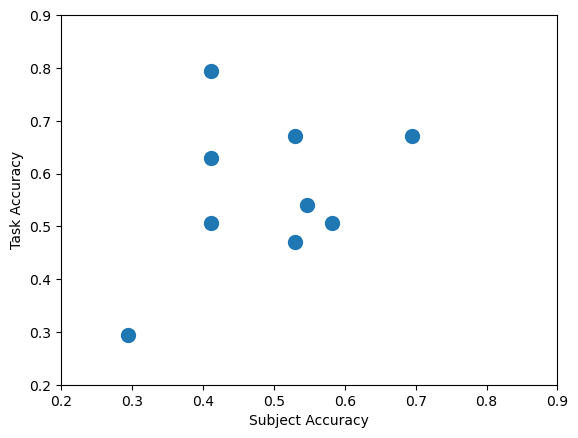

In [2461]:
plt.plot(accuracy_subj, accuracy_task, '.', markersize = 20)
ax = plt.gca()
ax.set_xlim([0.2, 0.9])
ax.set_ylim([0.2, 0.9])
ax.set_xlabel('Subject Accuracy')
ax.set_ylabel('Task Accuracy')

In [2413]:
subnets.head(50)

,ROI,subnet
0,11,1
1,18,1
2,19,1
3,73,1
4,115,1
5,118,1
6,119,1
7,120,1
8,121,1
9,122,1
